# 编译动态库

## link与动态库有关的选项

- 使用不带参数的link命令，可以直接输出link的选项帮助，选项很多，但是与动态库有关的常用的有：
    1. `/DLL`：编译PE格式的动态库
    2. `/IMPLIB:文件名`：输出使用时的import文件，就是lib文件
    3. `/EXPORT:导出函数名`：
    3. `/MACHINE:{ARM|ARM64|EBC|X64|X86}`：指定机器结构
    4. `/OUT:文件名`：输出的DLL库文件

- 提示：
    - 不导出函数，默认函数是无法调用的。

## 通用动态库编译过程

- 下面是编译动态库最原始、落后的方式。

```bash
CL_ARGS    = /EHsc  \
             /MD \
             /source-charset:utf-8  \
             /execution-charset:utf-8 \
             /nologo

LINK_ARGS  = /MACHINE:X64 /NOLOGO /DLL 

OUTFILE    = add.dll
LIBFILE    = add.lib
SOURCE     = add.c
OBJS       = add.obj

$(OUTFILE):$(SOURCE)
# 编译
    @cl /c $(CL_ARGS) /Fo:$(OBJS)  $(SOURCE)  /nologo
# 动态库
    @link $(LINK_ARGS) /OUT:$(OUTFILE) /IMPLIB:add.lib /EXPORT:yq_add  $(OBJS)
clean:
    @del *.obj *.dll *.pdb *.ilk *.exe *.lib  *.exp 2>/Nul

```

- 提示：
    - 不使用/EXPORT指定yq_add函数，则在后面的调用中会失败。

## 使用dumpbin查看动态库dll与lib文件

### 查看dll

- 命令：
    - `dumpbin /EXPORTS add.dll`

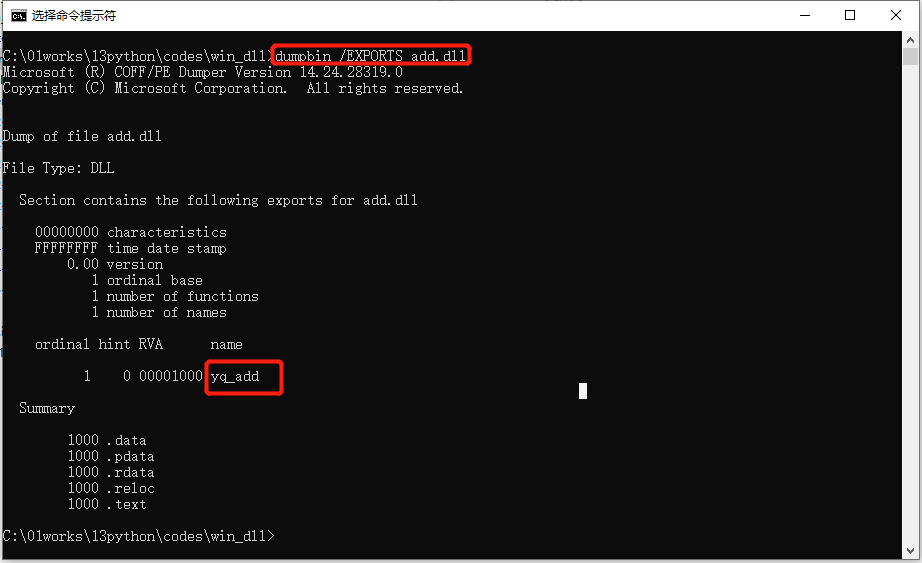

### 查看lib

- 命令：
    - `dumpbin /EXPORTS add.lib`

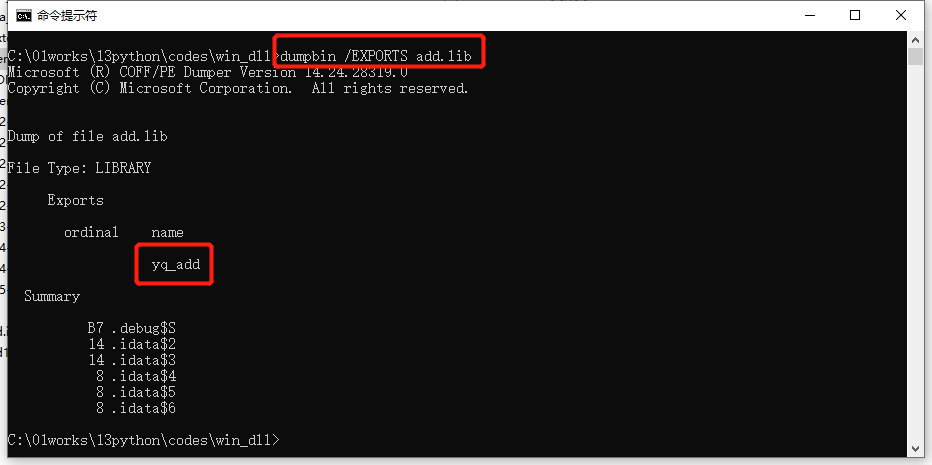

# 调用动态库

## 代码中动态调用

### window中动态可加载的几个函数

1. LoadLibrary函数
    - 加载dll动态库文件到内存。
    - 返回指向动态库存放的内存地址：HMODULE。
    - 参数：dll的路径与文件名。

```C++
HMODULE LoadLibraryA(
  LPCSTR lpLibFileName
);
```

2. GetProcAddress函数
    - 查找导出的函数；
    - 返回找到的函数地址：FARPROC
    - 参数：
        1. hModule：指向动态库内存的地址。
        2. 需要查找的函数名。

```C++
FARPROC GetProcAddress(
  HMODULE hModule,
  LPCSTR  lpProcName
);
```

3. FreeLibrary函数
    - 释放加载的dll模块。
    - 参数：
        - 需要释放的动态库内存地址。

```C++
BOOL FreeLibrary(
  HMODULE hLibModule
);
```

### 调用动态库的代码

```C++
#include <stdio.h>
#include <windows.h>
#include "add.h"


int main(int argc, char **argv){
    HMODULE h = LoadLibraryA("add.dll");
    if(h==NULL){
        printf("加载动态库文件失败\n");
        return -1;
    }
    else{
        printf("加载动态库文件成功:%p\n", h);
    }
    
    // 查找符号函数
    FARPROC f = GetProcAddress(h,"yq_add");
    if(f==NULL){
        printf("查找函数失败！\n");
        // 释放加载的库
        FreeLibrary(h);
        return -1;
    }
    else{
        printf("查找函数成功:%p\n", f);
    }

    // 调用函数
    int(*func)(int,int) = f;    // 函数指针赋值

    // 调用函数
    printf("调用结果:%d\n", func(200, 55));

    FreeLibrary(h);
    return 0;
}

```

### 动态库在window中的头文件与库

1. 头文件
    - `libloaderapi.h (include windows.h)`

2. 头文件路径(VC安装的路径)：
    - `C:/Program Files (x86)/Microsoft Visual Studio/2019/Enterprise/VC/Tools/MSVC/14.24.28314/include`

3. 动态库文件
    - 路径在系统路径
    - 库文件名：`Kernel32.lib` + `Kernel32.dll`

### 编译与执行脚本

- 这里为了操作表达独立与清晰，我使用了bat文件

```C++
@rem echo off
@echo 切换到UTF-8编码...
@chcp 65001  >/Nul
@echo 编译调用动态库的程序...
@cl /c /utf-8 /nologo /MD /I "C:/Program Files (x86)/Microsoft Visual Studio/2019/Enterprise/VC/Tools/MSVC/14.24.28314/include" /Fo:call_add.obj   call_add.c  >/Nul
@link /NOLOGO /OUT:main.exe /DYNAMICBASE Kernel32.lib call_add.obj  >/Nul
@echo 执行程序...
@main.exe

```

- 运行结果是这样滴

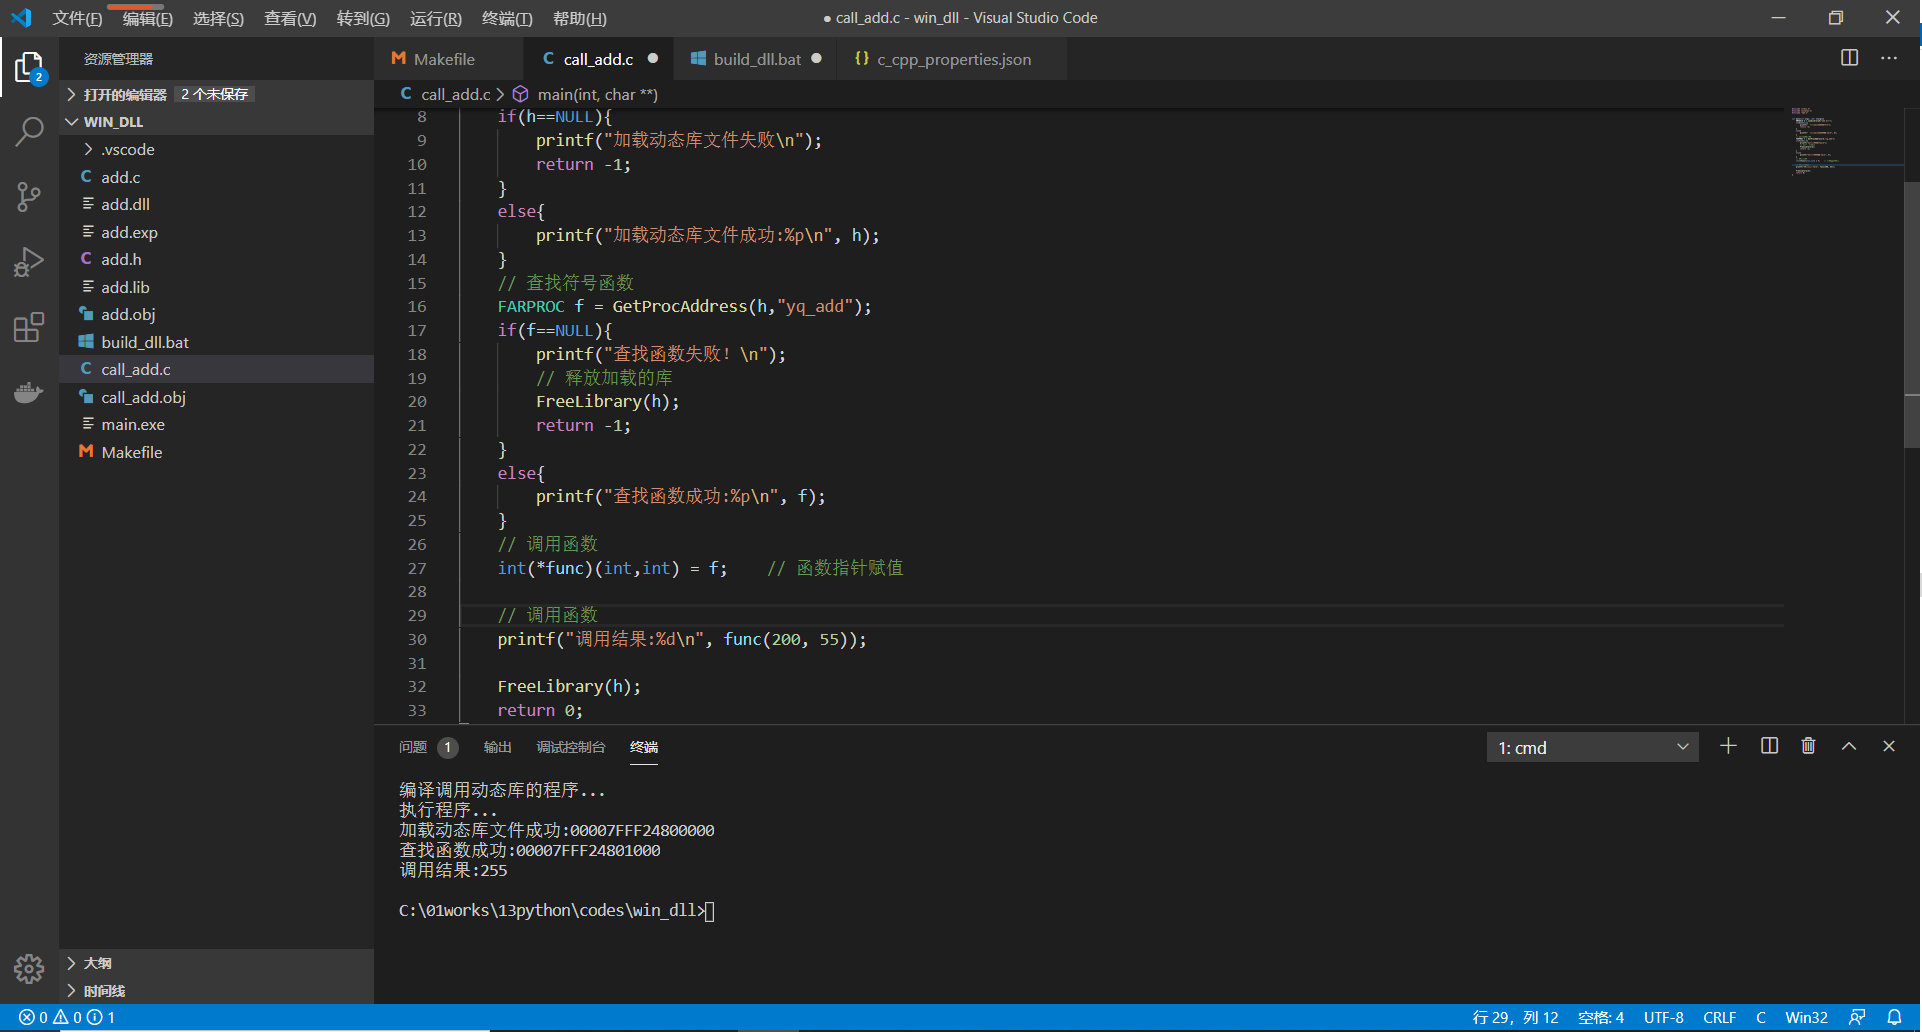

## 链接时调用

### 理解lib文件与dll文件

- 从上面的内容可以有如下几个结论：
    1. 编译动态库，只要指定导出的函数，就会产生一个lib文件。
    2. lib是静态库，是COFF格式。
    3. dll与执行文件exe一样都是PE格式。
    4. 使用dll的程序，不需要lib文件，不管是编译还是运行。

- 问题：
    - 在动态库创建的lib是做什么用的呢？是什么格式呢？COFF or PE？
        1. lib的类型是LIBRARY
        2. dll的类型是DLL

#### lib的头

```bash
C:\01works\13python\codes\win_dll>dumpbin /headers add.lib
Microsoft (R) COFF/PE Dumper Version 14.24.28319.0
Copyright (C) Microsoft Corporation.  All rights reserved.


Dump of file add.lib

File Type: LIBRARY

FILE HEADER VALUES
            8664 machine (x64)
               3 number of sections
        F0E3C762 time date stamp
             103 file pointer to symbol table
               8 number of symbols
               0 size of optional header
               0 characteristics
```

#### dll的头

```bash
C:\01works\13python\codes\win_dll>dumpbin /headers add.dll
Microsoft (R) COFF/PE Dumper Version 14.24.28319.0
Copyright (C) Microsoft Corporation.  All rights reserved.


Dump of file add.dll

PE signature found

File Type: DLL

FILE HEADER VALUES
            8664 machine (x64)
               5 number of sections
        5EB35238 time date stamp Thu May  7 08:11:36 2020
               0 file pointer to symbol table
               0 number of symbols
              F0 size of optional header
            2022 characteristics
                   Executable
                   Application can handle large (>2GB) addresses
                   DLL
```

#### lib与dll的关系与作用

1. lib是静态库，dll是动态库
    - lib的内容会被编译到执行文件（编译文件大，加载速度慢，但是运行速度快）
    - dll的内容在执行时加载（编译文件小，程序启动与运行速度取决于dll是否是lazy加载模式）

2. 使用动态库，程序运行时只使用dll，lib是不需要的。
    - lib是编译时使用的；
    - dll是运行时使用的；

3. dll动态库的使用方式
    - 使用LoadLibrary等函数访问，这种方式很麻烦。
    - 在编译时访问，借助lib来描述dll中需要访问的信息，并把访问信息借助lib静态库的形式编译到执行文件。
    - 下面可以在lib查询到lib与dll的关系。
    

```bash
C:\01works\13python\codes\win_dll>dumpbin /ARCHIVEMEMBERS add.lib
Microsoft (R) COFF/PE Dumper Version 14.24.28319.0
Copyright (C) Microsoft Corporation.  All rights reserved.


Dump of file add.lib

File Type: LIBRARY

Archive member name at 16E: add.dll/
FFFFFFFF time/date
         uid
         gid
       0 mode
     1DD size
correct header end

Archive member name at 388: add.dll/
FFFFFFFF time/date
         uid
         gid
       0 mode
      F6 size
correct header end

Archive member name at 4BA: add.dll/
FFFFFFFF time/date
         uid
         gid
       0 mode
     116 size
correct header end

Archive member name at 60C: add.dll/
FFFFFFFF time/date
         uid
         gid
       0 mode
      23 size
correct header end

  Summary

          B7 .debug$S
          14 .idata$2
          14 .idata$3
           8 .idata$4
           8 .idata$5
           8 .idata$6

C:\01works\13python\codes\win_dll>

```

4. lib的作用
    1. 用作独立的静态库；就是一般意义上的静态库；
    2. 用作描述dll的静态库；内部很多描述内容指向dll；
    3. lib与dll联合使用，只在编译时有用，编译结束，lib的内容被编译到执行文件。
    4. 通过动态库dll相关联的lib，使得dll的使用与lib的使用一样，统一了使用形式：不管是动态库还是静态库

5. 在Linux/mac系统
    - 动态库的内容是自描述的，不需要借助lib这样额外的文件来描述。使得Linux的动态可更加简洁，使用方便。
    - Linux的动态库是ELF格式，而不是PE格式。

### 调用代码

- 有了lib，我们使用动态库就像使用静态库一样方便，只有在运行时才有差异。
- 编译时不需要关注dll的存在，但运行时是必须要存在的。

```C++
#include <stdio.h>
#include "add.h"


int main(int argc, char **argv){
    printf("调用结果:%d\n", yq_add(200, 55));
    return 0;
}

```

### 编译脚本

```bash
CL_ARGS    = /EHsc  \
             /MD \
             /source-charset:utf-8  \
		     /execution-charset:utf-8 \
			 /nologo

LINK_ARGS  = /MACHINE:X64 /NOLOGO /DLL 

OUTFILE    = add.dll
LIBFILE    = add.lib
SOURCE     = add.c
OBJS       = add.obj


main: $(OUTFILE) call_add.c
#编译
	@cl  /c $(CL_ARGS)  /Fo:call_add.obj   call_add.c
#链接
	@link /NOLOGO /OUT:main.exe /DYNAMICBASE add.lib call_add.obj  >/Nul

$(OUTFILE):$(SOURCE)
# 编译
	@cl /c $(CL_ARGS) /Fo:$(OBJS)  $(SOURCE)
# 动态库
	@link $(LINK_ARGS) /OUT:$(OUTFILE) /EXPORT:yq_add $(OBJS)

clean:
	@del *.obj *.dll *.pdb *.ilk *.exe *.lib  *.exp 2>/Nul


```

### 查看编译后程序的动态库依赖

- 命令：`dumpbin /dependents  main.exe`

```bash
C:\01works\13python\codes\dll_lib> dumpbin /dependents  main.exe
Microsoft (R) COFF/PE Dumper Version 14.24.28319.0
Copyright (C) Microsoft Corporation.  All rights reserved.


Dump of file main.exe

File Type: EXECUTABLE IMAGE

  Image has the following dependencies:

    add.dll
    KERNEL32.dll
    VCRUNTIME140.dll
    api-ms-win-crt-stdio-l1-1-0.dll
    api-ms-win-crt-runtime-l1-1-0.dll
    api-ms-win-crt-math-l1-1-0.dll
    api-ms-win-crt-locale-l1-1-0.dll
    api-ms-win-crt-heap-l1-1-0.dll

  Summary

        1000 .data
        1000 .pdata
        1000 .rdata
        1000 .reloc
        1000 .text

C:\01works\13python\codes\dll_lib>
```

- 注意：
    - 删除lib，程序依然执行，lib负责编译时，dll库的符号映射。尤其C++编译后，很多函数名都改变。通过lib可以提供有个规则来映射。这样对开发人员来说就非常简捷。

## 使用`#pragma`

### 调用代码

- 通过`#pragma`使用lib，这样预处理自动处理相关的细节。

```C++
#include <stdio.h>
#include "add.h"
#pragma comment(lib, "add.lib") 

int main(int argc, char **argv){
    printf("调用结果:%d\n", yq_add(200, 55));
    return 0;
}

```

### 编译脚本

```bash
CL_ARGS    = /EHsc  \
             /MD \
             /source-charset:utf-8  \
		     /execution-charset:utf-8 \
			 /nologo

LINK_ARGS  = /MACHINE:X64 /NOLOGO /DLL 

OUTFILE    = add.dll
LIBFILE    = add.lib
SOURCE     = add.c
OBJS       = add.obj


main: $(OUTFILE) call_add.c
#编译
	@cl  /c $(CL_ARGS)  /Fo:call_add.obj   call_add.c
#链接
	@link /NOLOGO /OUT:main.exe call_add.obj  >/Nul

$(OUTFILE):$(SOURCE)
# 编译
	@cl /c $(CL_ARGS) /Fo:$(OBJS)  $(SOURCE)
# 动态库
	@link $(LINK_ARGS) /OUT:$(OUTFILE) /EXPORT:yq_add $(OBJS)

clean:
	@del *.obj *.dll *.pdb *.ilk *.exe *.lib  *.exp 2>/Nul


```

- 编译的时候，直接编译调用代码，编译的各种个条件就可以忽略(这里在编译的时候，就不需要指定lib库了)
    - `@link /NOLOGO /OUT:main.exe call_add.obj  >/Nul`

# 导出函数的三种方式

## 使用link中export命令行选项导出

- 这种方式导出多个函数，就显得很麻烦，需要指定多个。但是简单直观。
- 问题：
    - 导出变量，导出类的时候，就显得比较麻烦了。

- 具体的例子上面已经使用过。

## 使用微软`C/C++`语言语法导出

### 在函数声明前添加导出语法

```C++
#ifndef YQ_ADD_H
#define YQ_ADD_H
__declspec( dllexport)  extern int yq_add(int, int);
#endif

```

- 注意：
    - `__declspec( dllexport)`与`extern`不用计较顺序。

- 在实现文件不需要做任何改变

```C++
#include "add.h"

int yq_add(int p1, int p2){
    return p1 + p2;
}

```

### 调用代码

- 调用代码不需要做改变，因为我们关注的是动态库的问题。

```C++
#include <stdio.h>
#include "add.h"
#pragma comment(lib, "add.lib") 

int main(int argc, char **argv){
    printf("调用结果:%d\n", yq_add(200, 55));
    return 0;
}

```

### 编译脚本

- 重点是不需要使用export导出外部使用的函数了。

```bash
CL_ARGS    = /EHsc  \
             /MD \
             /source-charset:utf-8  \
		     /execution-charset:utf-8 \
			 /nologo

LINK_ARGS  = /MACHINE:X64 /NOLOGO /DLL 

OUTFILE    = add.dll
LIBFILE    = add.lib
SOURCE     = add.c
OBJS       = add.obj


main: $(OUTFILE) call_add.c
#编译
	@cl  /c $(CL_ARGS)  /Fo:call_add.obj   call_add.c
#链接
	@link /NOLOGO /OUT:main.exe call_add.obj  >/Nul

$(OUTFILE):$(SOURCE)
# 编译
	@cl /c $(CL_ARGS) /Fo:$(OBJS)  $(SOURCE)
# 动态库
	@link $(LINK_ARGS) /OUT:$(OUTFILE) $(OBJS)

clean:
	@del *.obj *.dll *.pdb *.ilk *.exe *.lib  *.exp 2>/Nul


```

- 动态库的编译：
    - `@link $(LINK_ARGS) /OUT:$(OUTFILE) $(OBJS)`

## 使用def定义文件导出

### def文件的语法规则

1. 语句、 属性关键字和用户标识字是区分大小写的。

2. 包含空格或分号 （;） 的长文件名必须括在引号 （"）中。

3. 使用一个或多个空格、 制表符或换行字符来分隔语句关键字与它的参数，也用来分隔语句。 
    - 用来指定参数的冒号 （:） 或等号 （=）需要使用零或多个空格、 制表符或换行字符包围。


4. NAME或LIBRARY语句如果使用，则必须在所有其他语句之前使用。

5. SECTIONS与EXPORTS语句可以出现多次。 每个语句可以遵循多个不同规范：必须由一个或多个空格、 制表符或换行字符分隔。 
    - 语句关键字必须在第一个规范之前出现一次，后面附加的规范可以重复。


6. 许多语句都具有等效的链接命令选项。可以参考对应的LINK选项。

7. 注释指定由分号 （;）开头，注释不能与def的语句共享一行，必须单独成行。但是注释可以出现的多规范语句的每个规范中间（SECTIONS与EXPORTS属于多规范语句）

8. 数值参数可以使用十进制或十六进制指定。

9. 如果字符串参数与保留字冲突，它必须括在双引号 （"）区分。

### 常用语句

#### LIBRARY语句

1. 语法：
    - `LIBRARY [library][BASE=address]`

2. 作用：
    - 告诉链接创建 DLL库。 同时，链接产生lib导入库文件；除非link中使用了.exp 文件。
    - 等同于`/DLL`与`/IMPLIB:lib文件`选项。
    - 参数library等于指定`/OUT:library`，但是可以使用`/OUT`指定来开覆盖。
    - `BASE=address`等于`/BASE`，默认是0x10000000。

#### NAME语句

1. 语法：
    - `NAME [application][BASE=address]`

2. 作用：
    - 等价于`/OUT`与`/BASE`选项，可以使用`/OUT`覆盖。

#### EXPORTS语句

1. 语法：
    - `EXPORTS
   definition`

2. 规则：
    - 第一个定义可以与EXPORTS关键字位于同一行上，也可以位于后续行上。 .DEF 文件可以包含一个或多个 EXPORTS 语句。

3. 定义的语法
    - `entryname[=internal_name|other_module.exported_name] [@ordinal [NONAME] ] [ [PRIVATE] | [DATA] ]`
    - entryname是要导出的函数或变量名称,这是必须要在定义中要求的;
    - 如果导出的名称与 DLL 中的名称不同，请使用internal_name在 DLL中指定导出的名称。见下面例子-1
    - 如果导出的名称来自其他模块，请使用other_module.exported_name在 DLL 中指定导出的名称。见下面例子-2
    - 如果导出的名称来自另一个模块导出的序号（ordinal），请使用other_module在 DLL中指定导出的序号other_module.#ordinal。见下面例子-3
    - 使用`__stdcall`或者`extern "C"`保持原函数名，但是微软支持C++，命名使用转换，前缀下划线`_`，后缀`@`以及参数列表字节。
        - 这个名称的变化使用dumpbin查看，或者使用/MAP选项导出。
    - NONAMR表示只能使用序号，不是用函数名。
    - PRIVATE 阻止函数在lib中产生，但是不妨碍DLL中的导出（意味着编译器无法使用，只能使用LoadLibrary动态加载）。
    - DATA表示导出的数据变量；

- 定义的例子-1：
    -  例如，如果 DLL 导出函数 func1，并且你希望调用方将其用作 func2，则应指定：
 
```
EXPORTS
   func2=func1
```

- 定义的例子-2
    - 例如：如果 DLL 导出函数 other_module.func1，并且你希望调用方将其用作 func2，则应指定：
    
```
EXPORTS
   func2=other_module.func1
```

- 定义的例子-3
    - 例如，如果DLL导出另外一个模块序号为42的函数，并且希望调用方将其用作func2，则可以指定：

    
```
EXPORTS
   func2=other_module.#42
```

### def文件编辑

- `add.h`与`add.c`还是上面的文件，但是采用def定义导出的函数。
    - def文件的文件名是：`add.def`

```c++
LIBRARY mod_add
EXPORTS
   mod_add = yq_add

```

### 使用def文件编译动态库

```bash
CL_ARGS    = /EHsc  \
             /MD \
             /source-charset:utf-8  \
		     /execution-charset:utf-8 \
			 /nologo

LINK_ARGS  = /MACHINE:X64 /NOLOGO /DLL 

OUTFILE    = add.dll
LIBFILE    = add.lib
SOURCE     = add.c
OBJS       = add.obj


main: $(OUTFILE) call_add.c
#编译
	@cl  /c $(CL_ARGS)  /Fo:call_add.obj   call_add.c >/Nul
#链接
	@link /NOLOGO /OUT:main.exe call_add.obj

$(OUTFILE):$(SOURCE)
# 编译
	@cl /c $(CL_ARGS) /Fo:$(OBJS)  $(SOURCE)
# 动态库
	@link $(LINK_ARGS) /DEF:add.def $(OBJS)

clean:
	@del *.obj *.dll *.pdb *.ilk *.exe *.lib  *.exp 2>/Nul


```

- 提示：
    - 使用`/DEF`指定def文件：`@link $(LINK_ARGS) /DEF:add.def $(OBJS)`
    - 编译后的dll文件命名为：`mod_add.dll`

- 查看导出的符号：
    - `dumpbin /exports mod_add.dll`

```bash
C:\01works\13python\codes\export_def>dumpbin /exports mod_add.dll
Microsoft (R) COFF/PE Dumper Version 14.24.28319.0        
Copyright (C) Microsoft Corporation.  All rights reserved.


Dump of file mod_add.dll

File Type: DLL

  Section contains the following exports for mod_add.dll

    00000000 characteristics
    FFFFFFFF time date stamp
        0.00 version
           1 ordinal base
           1 number of functions
           1 number of names

    ordinal hint RVA      name

          1    0 00001000 mod_add

  Summary

        1000 .data
        1000 .pdata
        1000 .rdata
        1000 .reloc
        1000 .text

C:\01works\13python\codes\export_def>
```

### 调用动态库

- 注意：
    - 头文件没有使用了。因为C是弱类型语言，所以在编译的时候，对mod_add函数没有做声明检测。
    - 对C++程序而言，建议与头文件保持一致。

```C++
#include <stdio.h>
#pragma comment(lib, "add.lib") 

int main(int argc, char **argv){
    printf("调用结果:%d\n", mod_add(200, 55));
    return 0;
}

```

--------

# 附录

- 说明：
    - lib中也可以指定def，用来声明导出的函数。这涉及exp文件的使用。下面抄录网上一段你话可以说明这个使用.
        - `https://www.cnblogs.com/chixinfushui/p/9019300.html`

> exp文件就是导出文件（export file）。在前面的讨论中，我们讨论了使用linker去创建dll（中间还有它的导出库）现在，我们假设我们生成两个dll（or just executables）。但是他们都需要调用一些对方中函数，问题出现了。当我们生成a.dll的时候我们需要b.lib；但是b.lib在对应的b.dll生成之前没有生成，而b.dll的生成又需要a.lib。正因如此，微软的解决办法是使用exp文件，或者叫导出文件。在生成两个dll之前，你使用lib.exe(library mangager tool库管理工具)来创建一个.lib和.exp，即，DLL A 的a.lib 和a.exp，现在linker使用a.lib和DLL B 自己的东西去生成b.dll和b.lib。当你回来链接DLL A的时候你就有了b.lib。这里linker需要知道a.dll中需要导出处啥。这些信息都被缓存到了a.exp文件中。linker不需要def文件或者/EXPORT选项，它仅仅是加载a.exp中的信息。a.exp就像a.dll的两个生成过程（lib.exe and linker）的联系者一样。相似的，linker不会再次生成a.lib。总的来说，这种循环调用的情况不会和在我们的程序中出现，因此，希望你不会再你的程序中用到exp文件。

------